In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src.room_and_object_types import CATEGORIES_TO_TYPES, EMPTY_OBJECT
from src.fitness_features import COMMON_SENSE_PREDICATES_FUNCTIONS, PREDICATE_FUNCTION_ARITY_MAP
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
# temporary hack
# if 'text_ngram_score' in fitness_df.columns and fitness_df.text_ngram_score.min() >= 0:
#     fitness_df.text_ngram_score = np.log(fitness_df.text_ngram_score)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_n_5_0,ast_ngram_n_5_1,ast_ngram_n_5_2,ast_ngram_n_5_3,ast_ngram_n_5_4,ast_ngram_n_5_5,ast_ngram_n_5_6,ast_ngram_n_5_7,ast_ngram_n_5_8,ast_ngram_n_5_9
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,4,4,2,3,1,2,1,1,1,2
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,1,1,0,2,0,2,0,2,2,1
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,0,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,2,2,2,2,2,2,1,1,1,1
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,3,2,0,2,4,2,3,2,2,2


In [7]:
BINARIZE_IGNORE_FEATURES = [
    'setup_objects_used', 'starts_and_ends_once', 'correct_predicate_function_arity',
    'section_without_pref_or_total_count_terminal', 'section_without_pref_or_total_count_scoring'
]  

BINARIZE_IGNORE_PATTERNS = [
    re.compile(r'max_depth_[\w\d_]+'), 
    re.compile(r'mean_depth_[\w\d_]+'), 
    re.compile(r'node_count_[\w\d_]+')
]  

BINARIZE_NON_ONE = [
    'all_variables_defined', 'all_variables_used', 
    'all_preferences_used', 'no_adjacent_once', 'variable_not_repeated',
    'no_nested_logicals', 'no_identical_logical_children',     
    'count_once_per_external_objects_used_correctly',         
    'external_forall_used_correctly', 'pref_forall_used',        
    'pref_forall_correct_arity', 'pref_forall_correct_types', 'no_two_number_operations',
    'tautological_expression_found', 'redundant_expression_found',
]  

SCALE_ZERO_ONE_PATTERNS = [
    re.compile(r'(ast|text)_ngram_n_\d+_score'),
]

BINRARIZE_NONZERO_PATTERNS = [
    re.compile(r'arg_types_[\w_]+'), 
    re.compile(r'compositionality_structure_\d+'),
    re.compile(r'(ast|text)_ngram_n_\d+_\d+')
]   


def _update_single_series(series: pd.Series, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS):
    c = str(series.name)
    if c in ignore_columns:
        return series

    if c in BINARIZE_IGNORE_FEATURES:
        return series
    
    if any([p.match(c) for p in BINARIZE_IGNORE_PATTERNS]):
        return series

    if c in BINARIZE_NON_ONE:
        return (series == 1).astype(int)
    
    if any([p.match(c) for p in SCALE_ZERO_ONE_PATTERNS]):
        min_val, max_val = series.min(), series.max()
        return (series - min_val) / (max_val - min_val)

    if any([p.match(c) for p in BINRARIZE_NONZERO_PATTERNS]):
        return (series != 0).astype(int)
    
    raise ValueError(f'No binarization rule for column {c}')


def binarize_features(df: pd.DataFrame, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS) -> pd.DataFrame:
    binarized_df = df.apply(_update_single_series, axis=0, ignore_columns=ignore_columns)
    return binarized_df


binarized_df = binarize_features(fitness_df)
binarized_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_n_5_0,ast_ngram_n_5_1,ast_ngram_n_5_2,ast_ngram_n_5_3,ast_ngram_n_5_4,ast_ngram_n_5_5,ast_ngram_n_5_6,ast_ngram_n_5_7,ast_ngram_n_5_8,ast_ngram_n_5_9
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,1,1,1,1,1,1,1,1,1,1
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,1,1,0,1,0,1,0,1,1,1
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,1,0,0,0,0,0,0,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,1,1,1,1,1,1,1,1,1,1
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,1,1,0,1,1,1,1,1,1,1


In [8]:
def _merge_single_prefix(df: pd.DataFrame, feature_prefix: str, threshold: int = 10, 
    merge_function: typing.Callable = np.logical_or, merged_column_suffix: str = 'other', feature_suffix: str = '') -> None:
    
    index_feature_names = [c for c in df.columns if c.startswith(f'{feature_prefix}_ramps') and c.endswith(feature_suffix)]
    if len(index_feature_names) == 0:
        print(f'No index feature found for prefix {feature_prefix}')
        return
    
    index_feature_name = index_feature_names[0]
    insert_index = list(df.columns).index(index_feature_name)

    counts = df[[c for c in df.columns if c.startswith(feature_prefix) and c.endswith(feature_suffix)]].sum()
    keys_to_merge = counts.index[counts < threshold]  # type: ignore
    if len(keys_to_merge) == 0:
        print(feature_prefix)
        return
    new_series_values = reduce(merge_function, [df[k] for k in keys_to_merge[1:]], df[keys_to_merge[0]]).astype(int)
    
    merged_column_key = f'{feature_prefix}_{merged_column_suffix}{"_" + feature_suffix if feature_suffix else ""}'
    df.insert(insert_index, merged_column_key, new_series_values)
    df.drop(keys_to_merge, axis=1, inplace=True)
    

def merge_sparse_features(df: pd.DataFrame, threshold: int = 10, 
    merge_function: typing.Callable = np.logical_or, merged_column_suffix: str = 'other',
    predicates: typing.Sequence[str] = COMMON_SENSE_PREDICATES_FUNCTIONS) -> pd.DataFrame:
    df = df.copy(deep=True)

    for feature_suffix in ('setup', 'constraints'):
        for p in predicates:
            feature_prefix = f'arg_types_{p}'
            _merge_single_prefix(df, feature_prefix, threshold, merge_function, merged_column_suffix, feature_suffix)

            # if p not in PREDICATE_FUNCTION_ARITY_MAP:
            #     raise ValueError(f'Predicate {p} not in arity map')

            # arity = PREDICATE_FUNCTION_ARITY_MAP[p]
            # if arity == 1:
            #     feature_prefix = f'arg_types_{p}'
            #     _merge_single_prefix(df, feature_prefix, threshold, merge_function, merged_column_suffix, feature_suffix)

            # else:  # arity = 2/3
            #     for c in CATEGORIES_TO_TYPES.keys():
            #         if c == EMPTY_OBJECT:
            #             continue
            #         feature_prefix = f'arg_types_{p}_{c}'
            #         _merge_single_prefix(df, feature_prefix, threshold, merge_function, merged_column_suffix, feature_suffix)

    return df
                


In [9]:
merged_binarized_df = merge_sparse_features(binarized_df, threshold=10, predicates=COMMON_SENSE_PREDICATES_FUNCTIONS)
print(binarized_df.shape, '=>', merged_binarized_df.shape)
merged_binarized_df.head()

arg_types_in_motion
arg_types_agent_holds
arg_types_in_motion
(12642, 2203) => (12642, 576)


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_n_5_0,ast_ngram_n_5_1,ast_ngram_n_5_2,ast_ngram_n_5_3,ast_ngram_n_5_4,ast_ngram_n_5_5,ast_ngram_n_5_6,ast_ngram_n_5_7,ast_ngram_n_5_8,ast_ngram_n_5_9
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,1,1,1,1,1,1,1,1,1,1
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,1,1,0,1,0,1,0,1,1,1
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,1,0,0,0,0,0,0,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,1,1,1,1,1,1,1,1,1,1
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,1,1,0,1,1,1,1,1,1,1


**TODO**: theoretically we'd want to first train-test split and then merge features, but for a quick POC I'm doing it in the opposite order

Train tensor shape: torch.Size([78, 129, 570]) | Test tensor shape: torch.Size([20, 129, 570])
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


### Test results:

{'ecdf': -0.08038759689922481, 'game_rank': 0.981249988079071}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
248,2,32,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.0,-0.134432,0.017246,1,0.968984,0.005276,8
316,2,64,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.0,-0.137505,0.020853,2,0.969707,0.004718,2
124,2,8,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.0,-0.138282,0.024200,3,0.968008,0.005109,15
120,2,8,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.0,-0.138463,0.022804,4,0.965137,0.005742,32
252,2,32,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.0,-0.140997,0.016711,5,0.969290,0.005025,4
312,2,64,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.0,-0.141872,0.020454,6,0.969102,0.005816,5
184,2,16,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.0,-0.143548,0.015022,7,0.967064,0.005053,18
636,4,64,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.0,-0.144525,0.019441,8,0.968411,0.004475,13
188,2,16,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.0,-0.145170,0.019695,9,0.970234,0.004856,1
632,4,64,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.0,-0.146633,0.013636,10,0.966224,0.006949,23


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
188,2,16,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.00,-0.145170,0.019695,9,0.970234,0.004856,1
316,2,64,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.00,-0.137505,0.020853,2,0.969707,0.004718,2
253,2,32,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.25,-0.152207,0.022003,16,0.969388,0.004509,3
252,2,32,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.00,-0.140997,0.016711,5,0.969290,0.005025,4
312,2,64,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.00,-0.141872,0.020454,6,0.969102,0.005816,5
189,2,16,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.25,-0.155061,0.017400,22,0.969089,0.004742,6
313,2,64,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.25,-0.155824,0.024082,25,0.969004,0.005931,7
248,2,32,<function fitness_square_square_loss at 0x7f9a...,0.003,4,570,0.00,-0.134432,0.017246,1,0.968984,0.005276,8
508,4,16,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.00,-0.152311,0.025608,17,0.968802,0.005518,9
317,2,64,<function fitness_square_square_loss at 0x7f9a...,0.003,8,570,0.25,-0.153292,0.021796,19,0.968802,0.005528,9


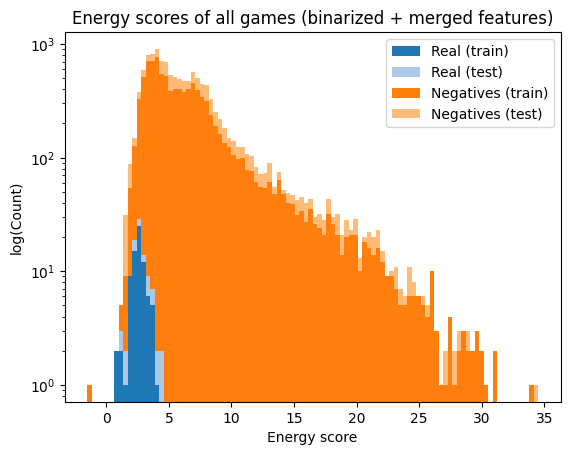

0.06640308 0.40972337 0.742571


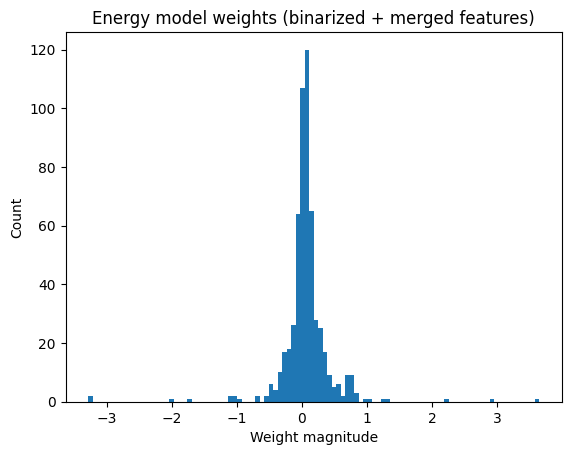

In [10]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_merged_binarized_features_sq_sq, (train_tensor_merged_binarized_features_sq_sq, test_tensor_merged_binarized_features_sq_sq), test_results_merged_binarized_features_sq_sq = utils.model_fitting_experiment(
    merged_binarized_df, test_param_grid, random_seed=42,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_merged_binarized_features_sq_sq, train_tensor_merged_binarized_features_sq_sq, test_tensor_merged_binarized_features_sq_sq, test_results_merged_binarized_features_sq_sq, histogram_title_note='binarized + merged features')

In [15]:
(np.arange(1, 100) / (98 * 129)).mean()

0.003955070400253125

In [ ]:
# cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = True
if SAVE_MODEL:
    output_path = f'../models/cv_fitness_model_binarized_merging_{datetime.now().strftime("%Y_%m_%d")}.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv_merged_binarized_features_sq_sq.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
feature_columns = [c for c in merged_binarized_df.columns if c not in NON_FEATURE_COLUMNS]
full_merged_binarized_tensor = utils.df_to_tensor(merged_binarized_df, feature_columns)
full_tensor_scores = cv_merged_binarized_features_sq_sq.best_estimator_.transform(full_merged_binarized_tensor).detach()

In [ ]:
energy_diffs = (full_tensor_scores[:, 1:] - full_tensor_scores[:, 0].unsqueeze(1)).ravel().numpy()
energy_diffs.shape

In [ ]:
regrown_game_texts[0]

In [ ]:
def extract_regrowth_depth(game_text: str):
    game_id_start = game_text.find('(game')
    game_id_section = game_text[game_id_start:game_text.find(')', game_id_start)]
    rightmost_dash = game_id_section.rfind('-')
    regrowth_depth = game_id_section[game_id_section.rfind('-') + 3:]
    penultimate_dash = game_id_section.rfind('-', 0, rightmost_dash)
    node_depth = game_id_section[penultimate_dash + 3:rightmost_dash]
    return int(node_depth), int(regrowth_depth)

depths = [extract_regrowth_depth(g) for g in regrown_game_texts]
node_depths, regrowth_depths = zip(*depths)

In [ ]:
depths_by_tuple = defaultdict(list)

for i, depth_tuple in enumerate(depths):
    depths_by_tuple[depth_tuple].append(energy_diffs[i])

visit_counts = np.zeros((max(node_depths) + 1, max(regrowth_depths) + 1))
mean_energies = np.zeros((max(node_depths) + 1, max(regrowth_depths) + 1))
for n_d, r_d in depths_by_tuple.keys():
    mean_energies[n_d, r_d] = np.mean(depths_by_tuple[(n_d, r_d)])
    visit_counts[n_d, r_d] = len(depths_by_tuple[(n_d, r_d)])

mean_energies.shape

In [ ]:
plt.imshow(mean_energies, cmap='hot', origin='lower')
plt.xlim(min(regrowth_depths) - 0.5, max(regrowth_depths) + 0.5)
plt.ylim(min(node_depths) - 0.5, max(node_depths) + 0.5)

plt.xlabel('Depth of regrown sub-tree')
plt.ylabel('Depth in original tree of mutation node')

plt.colorbar(label='Mean energy difference (regrown - original)')
plt.title('Effect of node and regrowth depth on energy difference')


In [ ]:
plt.imshow(visit_counts, cmap='bone', origin='lower')
plt.xlim(min(regrowth_depths) - 0.5, max(regrowth_depths) + 0.5)
plt.ylim(min(node_depths) - 0.5, max(node_depths) + 0.5)

plt.xlabel('Depth of regrown sub-tree')
plt.ylabel('Depth in original tree of mutation node')

plt.colorbar(label='# of regrown games at this cell')
plt.title('Number of regrown games at each node and regrowth depth')


In [ ]:
mean_energies[113 // mean_energies.shape[1], 113 % mean_energies.shape[1]]